# Hybrid Search Retrival Pipeline directly from Pinecone


In [2]:
from llama_index.core import VectorStoreIndex
from llama_index.core.retrievers import QueryFusionRetriever
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core import StorageContext
from llama_index.vector_stores.pinecone import PineconeVectorStore
from pinecone import Pinecone
import os
from llama_index.core.llms import MockLLM
from dotenv import load_dotenv
load_dotenv()


pc = Pinecone(api_key=os.getenv("PINECONE_API"))
pinecone_index = pc.Index("pubmed-abstracts")

# Just point to the folder where you persisted
storage_context = StorageContext.from_defaults(persist_dir="pubmed_nodes")

# Access to persisted documents
docstore = storage_context.docstore

vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
storage_context = StorageContext.from_defaults(vector_store=vector_store,docstore=docstore)

print("Number of nodes sored in docstore:", len(docstore.docs))

embed_model = HuggingFaceEmbedding(model_name="NeuML/pubmedbert-base-embeddings")

index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    storage_context=storage_context,
    embed_model=embed_model
)


bm25_retriever = BM25Retriever.from_defaults(
    docstore=docstore,
    similarity_top_k=5
)
vector_retriever = index.as_retriever(similarity_top_k=5)

alpha = 0.6

# Fusion retriever (merges multiple retrievers)
hybrid_retriever = QueryFusionRetriever(
    retrievers=[bm25_retriever, vector_retriever],
    retriever_weights=[alpha, 1 - alpha],
    num_queries=1,  # optional: for query rewriting
    llm= MockLLM(),
    mode="reciprocal_rerank",  # or "simple"
    use_async=True,
    similarity_top_k=3
    
)


Number of nodes sored in docstore: 531


### Opitional: Debug Keyword Retriever

In [ ]:
# keyword_result = bm25_retriever.retrieve(query)
# # Display results
# for res in keyword_result:
#     print("Score:", res.score)
#     print("Text:", res.node.text)
#     print("PMID:", res.node.metadata.get("PMID"))
#     print("Type:", res.node.metadata.get("type"))
#     print("-" * 80)

### Opitional: Debug Vector Retriever

In [ ]:
# vector_result = vector_retriever.retrieve(query)
# # Display results
# for res in vector_result:
#     print("Score:", res.score)
#     print("Text:", res.node.text)
#     print("PMID:", res.node.metadata.get("PMID"))
#     print("Type:", res.node.metadata.get("type"))
#     print("-" * 80)

### LLM integration with resources tracking 

In [3]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate


# Create a strict prompt
strict_prompt = PromptTemplate(
    "You are an expert assistant that answers questions using ONLY the provided context.\n"
    "Context:\n{context_str}\n\n"
    "Important Rules:\n"
        "- Answer ONLY based on the provided context documents"
        "- Do not use your own knowledge"
        "- If the answer is not in the context, say 'This information is not available in the provided documents'"
    "Question: {query_str}\n"
    "Answer:"
)



class TrackedRetrieverQueryEngine:
    """Wrapper around RetrieverQueryEngine that tracks and displays source metadata"""
    
    def __init__(self, query_engine):
        """Wrap an existing query engine"""
        self.query_engine = query_engine
    
    def query(self, query_str):
        # Retrieve nodes first
        nodes = self.query_engine.retriever.retrieve(query_str)
        
        # Call the wrapped query engine
        response = self.query_engine.query(query_str)
        
        # Display response with source metadata
        self._display_response_with_sources(query_str,response, nodes)
        
        return response
    
    def _display_response_with_sources(self, query_str,response, nodes):
        """Display the LLM response along with source metadata"""
        
        print("\n" + "=" * 80)
        print("LLM RESPONSE WITH SOURCE TRACKING")
        print("=" * 80)
        print(f"\nQuery: {query_str}\n")
        print("RESPONSE:")
        print("-" * 80)
        print(response)
        print("-" * 80)
        
        print("\n\nSOURCE NODES USED:")
        print("=" * 80)
        
        for i, node_with_score in enumerate(nodes, 1):
            node = node_with_score.node
            metadata = node.metadata
            
            print(f"\n[Source {i}]")
            print(f"  Root Name: {metadata.get('root_name', 'N/A')}")
            print(f"  PMID: {metadata.get('PMID', 'N/A')}")
            print(f"  Published Year: {metadata.get('published_year', 'N/A')}")
            print(f"  Neuraci Type: {metadata.get('neuraci_type', ['N/A'])}")
            print(f"  URL: {metadata.get('url', 'N/A')}")
            print(f"  Relevance Score: {node_with_score.score:.4f}")
          
        
        print("\n" + "=" * 80 + "\n")



llm_querying = OpenAI(model="gpt-4o", api_key=os.getenv("OPEN_AI_API"))

# Wrap with a query engine
query_engine = RetrieverQueryEngine.from_args(
    retriever= hybrid_retriever,
    llm=llm_querying,
    text_qa_template=strict_prompt 
)


# Wrap it with the tracker
tracked_query_engine = TrackedRetrieverQueryEngine(query_engine)

# Run query - now it will display response + source metadata
query_0 = "What are the effects of patchouli oil?"
query_1= "What bioactive compounds are found in the leaves of Pogostemon cablin"
query_2 = "What agents are commonly used for anaesthetic baths in decapod crustaceans?"
query_3 = "What are the uses of Sandalwood?"
query_6 = "What are negative effects of Ylang Ylang?"
query_4 = "What are the uses of patchouli oil?"
query_5 = "What are the uses of Ylang Ylang?"

response = tracked_query_engine.query(query_0)


LLM RESPONSE WITH SOURCE TRACKING

Query: What are the effects of patchouli oil?

RESPONSE:
--------------------------------------------------------------------------------
Patchouli oil has various effects, including anti-peptic ulcer, antimicrobial, anti-oxidative, anti-inflammatory, analgesic, antitumor, antidiabetic, anti-hypertensive, and immunoregulatory effects. It also has antibacterial and antifungal activity, effectively inhibiting 20 bacteria and all twelve fungi tested. Additionally, inhalation of patchouli oil has been shown to reduce stress and increase compassion satisfaction in emergency nurses.
--------------------------------------------------------------------------------


SOURCE NODES USED:

[Source 1]
  Root Name: Patchouli
  PMID: 33413544
  Published Year: 2021
  Neuraci Type: Observational Studies & Reviews
  URL: https://pubmed.ncbi.nlm.nih.gov/33413544/
  Relevance Score: 0.0167

[Source 2]
  Root Name: Patchouli
  PMID: 8893526
  Published Year: 1996
  Neur

# Evaluation

In [ ]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
    RetrieverEvaluator
)
from llama_index.core.schema import MetadataMode, TextNode
import uuid
from typing import List, Any
import random
from llama_index.llms.openai import OpenAI
import asyncio
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
pubmed_literature_search_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the above biomedical context (and not external knowledge), \
generate {num_questions_per_chunk} PubMed literature-style search queries.

Task:
Your task is to write realistic PubMed or biomedical database search queries \
that a researcher or clinician might use to retrieve this abstract. \
Restrict the queries strictly to the information provided.

Explanation of Literature-style search queries:
Concise keyword-based or natural-language queries similar to what researchers enter into PubMed or Google Scholar.

Example queries:
1. "role of IL-6 in inflammatory bowel disease"
2. "oxidative stress biomarkers in Alzheimer’s progression"
3. "COVID-19 vaccine efficacy in immunocompromised adults"
"""

pubmed_concept_seeking_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} concept-seeking biomedical questions.

Task:
Your task is to create abstract or high-level conceptual questions \
that require multi-sentence explanations, reasoning, or interpretation \
based only on the provided biomedical abstract.

Explanation of Concept-seeking questions:
These are open-ended research-style questions that probe mechanisms, hypotheses, or conceptual relationships.

Example queries:
1. "How does mitochondrial dysfunction contribute to neurodegenerative diseases?"
2. "Why is the gut microbiome considered a key regulator of immune homeostasis?"
3. "What mechanisms link chronic inflammation to cancer initiation?"
"""


pubmed_fact_seeking_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} fact-seeking biomedical questions.

Task:
Your task is to write precise fact-based questions \
that can be directly answered from the information in the abstract. \
Restrict the questions to the factual content provided.

Explanation of Fact-seeking questions:
Specific questions with clear, verifiable answers from the text.

Example queries:
1. "What concentration of drug X inhibited tumor growth in mice?"
2. "Which cytokines were upregulated following infection?"
3. "How many participants were included in the clinical trial?"
"""

pubmed_keyword_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} keyword-style biomedical queries.

Task:
Your task is to write compact keyword-based queries \
that capture the key biomedical terms, entities, or relationships \
from the given abstract. Restrict the output to only the key terms.

Explanation of Keyword queries:
Short, information-dense phrases focusing on diseases, genes, pathways, or treatments.

Example queries:
1. "apoptosis p53 regulation"
2. "insulin resistance type 2 diabetes"
3. "CRISPR Cas9 gene editing therapy"
"""

pubmed_queries_with_misspellings_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} biomedical queries with misspellings.

Task:
Your task is to create search-like queries that intentionally include \
common spelling mistakes, transpositions, missing characters, \
and typical human typing errors while still resembling biomedical queries. \
Restrict the misspelled words to terms that appear or are derived from the context.

Explanation of Queries with Misspellings:
These mimic noisy user input where biomedical terms may be misspelled or mistyped.

Example queries:
1. "mitochodrial dysfuncton in Alzhimers"
2. "inflamation markrs in arthrits"
3. "oxdatve stres biomarkrs in cancer"
"""



In [ ]:
def create_word_based_search_queries(text, num_questions_per_chunk, min_words=5, max_words=15):
    """
    Create search queries by randomly selecting a substring of complete words.

    :param text: Text string.
    :param min_words: Minimum number of words in the substring.
    :param max_words: Maximum number of words in the substring.
    :return: List of search queries.
    """
    words = text.split()
    queries = []

    if len(words) < min_words:
        return [text]

    for _ in range(num_questions_per_chunk):  # Generate multiple queries per text
        start_index = random.randint(0, len(words) - min_words)
        end_index = random.randint(start_index + min_words, min(start_index + max_words, len(words)))
        substring = ' '.join(words[start_index:end_index])
        queries.append(substring)

    return queries

def generate_query_context_pairs(
    nodes: List[TextNode],
    num_questions_per_chunk: int = 2,
    min_words=5,
    max_words=15
) -> EmbeddingQAFinetuneDataset:
    """Generate examples given a set of nodes."""
    node_dict = {
        node.node_id: node.get_content(metadata_mode=MetadataMode.NONE)
        for node in nodes
    }

    queries = {}
    relevant_docs = {}
    for node_id, text in node_dict.items():
        generated_queries = create_word_based_search_queries(text,
                                                             num_questions_per_chunk,
                                                             min_words,
                                                             max_words)

        for query in generated_queries:
            question_id = str(uuid.uuid4())
            queries[question_id] = query
            relevant_docs[question_id] = [node_id]

    # construct dataset
    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()
# Deing LLM for query generation
llm = OpenAI(model='gpt-4o-mini', temperature=0.1,api_key=os.getenv("OPEN_AI_API"))

In [ ]:
from llama_index.core.storage.docstore import SimpleDocumentStore

# Load the document store from the persisted JSON
docstore = SimpleDocumentStore.from_persist_path("pubmed_nodes/docstore.json")

# Extract all nodes (TextNode objects)
all_nodes = list(docstore.docs.values())

print(f"✅ Loaded {len(all_nodes)} nodes from docstore.json")


✅ Loaded 531 nodes from docstore.json


In [ ]:
# Literature search queries
literature_search_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_literature_search_queries_tmpl
)

# Concept seeking queries
concept_seeking_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_concept_seeking_queries_tmpl
)

# Fact seeking queries
fact_seeking_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_fact_seeking_queries_tmpl
)

# Keyword queries
keyword_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_keyword_queries_tmpl
)

# Queries with misspellings
queries_with_misspellings_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_queries_with_misspellings_tmpl
)

# Exact string match queries
exact_string_search_queries_multi_document = generate_query_context_pairs(all_nodes, num_questions_per_chunk=1)

100%|██████████| 531/531 [16:29<00:00,  1.86s/it]    


### Examine synthetically created queries from multiple documents.

In [ ]:
start_idx = 150
end_idx = 160

In [ ]:
# Literature search queries
queries = list(literature_search_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['"adulteration of botanical ingredients in phytomedicines and dietary supplements"',
 '"effects of Hypericum perforatum and Curcuma longa on health"',
 '"Santalum genus phytochemical constituents biological activities health effects"',
 '"Santalum genus bioactive compounds essential oil α-santalol β-santalol"',
 '"sandalwood extract bioactivities antioxidant anti-inflammatory antibacterial antifungal antiviral neuroleptic antihyperglycemic antihyperlipidemic anticancer"',
 '"anaesthesia techniques in decapod crustaceans"',
 '"anaesthesia and analgesia in decapod crustaceans"',
 '"decapod welfare pain management chlorpromazine essential oils"',
 '"transcriptome profiling high low oil yielding Santalum album"',
 '"Santalum album oil biosynthesis transcriptome analysis"']

In [ ]:
# concept seeking queries
queries = list(concept_seeking_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['What are the implications of botanical ingredient adulteration on public health and consumer trust in herbal medicines and dietary supplements?',
 'What are the potential therapeutic mechanisms of action for John’s wort and turmeric in the treatment of mood disorders and inflammation, respectively?',
 'What specific phytochemical constituents found in the Santalum genus contribute to its biological activities, and how do these constituents promote health benefits in humans?',
 'What are the potential therapeutic implications of the bioactive compounds found in the Santalum genus, particularly in relation to their traditional medicinal uses and modern bioactivities?',
 'What are the underlying mechanisms through which sandalwood extract exerts its diverse biological activities, such as antioxidant and anticancer effects, and how might these mechanisms be leveraged in the development of therapeutic applications in the pharmaceutical and biomedical industries?',
 'What are the physiolog

In [ ]:
# fact seeking queries
queries = list(fact_seeking_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['What are some examples of botanical ingredients that are at risk of adulteration?',
 '"What are the scientific names of John\'s wort and turmeric?"',
 'What are the biological activities associated with the Santalum genus?',
 'What bioactive compounds are reported to be present in sandalwood?',
 'What biological activities and health-promoting effects have been associated with sandalwood extract?',
 '"What type of organisms are discussed in the context of anaesthesia in the abstract?"',
 'What agents are commonly used for anaesthetic baths in decapod crustaceans?',
 'What substances are mentioned in the abstract that are related to the welfare and ethical treatment of decapods?',
 'What is being compared in the transcriptome profiling study of Santalum album L.?',
 'What are the two genotypes of Santalum album targeted for analysis in the study?']

In [ ]:
# keyword queries
queries = list(keyword_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['"patchouli leaves phytochemicals pharmacology"',
 '"Pogostemon cablin phytochemicals pharmacological properties"',
 '"patchouli leaves medicinal applications"',
 '"toxicology variant oils nanoemulsions Rhipicephalus sanguineus"',
 '"tick control essential oils nanoemulsions"']

In [ ]:
# queries with misspellings
queries = list(queries_with_misspellings_multi_document.queries.values())
queries[start_idx:end_idx]


['"patchoulli leavs phytochemicls and therapeitic uses"',
 '"phytochemicl compoition of patcholi leaves and therpeutic aplications"',
 '"patchoulli leavs medicinal aplications"',
 '"comparitve toxcity of three varient oils on Rhipicephalus sanguinues"',
 '"acaricidal activty of esssential oils in tick control"']

In [ ]:

# exact string search queries
queries = list(exact_string_search_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['Leaves: A Comprehensive Review of Phytochemical and Pharmacological Insights.',
 'Patchouli has a longstanding historical use as',
 'Ultimately, this review underscores the need for further research to validate and develop the medicinal',
 'variant oils and their nanoemulsions',
 'nm & 0.221) and (164.2 nm &']

### Format multiple document queries

In [ ]:
# Create dataset dictionaries for multiple document queries
datasets_multi_document = {
    "literature_search_queries": literature_search_queries_multi_document,
    "concept_seeking_queries": concept_seeking_queries_multi_document,
    "fact_seeking_queries": fact_seeking_queries_multi_document,
    "keyword_queries": keyword_queries_multi_document,
    "queries_with_misspellings": queries_with_misspellings_multi_document,
    'exact_string_search_queries': exact_string_search_queries_multi_document
}

### Define functions for retriever evaluation and metrics computation

We will look into retriever performance for various different `alpha` values without reranker.

In [ ]:
# Alpha values and datasets to test
alpha_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
#alpha_values = [1,]

# Function to evaluate retriever and return results
async def evaluate_retriever(alpha, dataset, reranker=None):

    hybrid_retriever = QueryFusionRetriever(
    retrievers=[vector_retriever, bm25_retriever],
    retriever_weights=[alpha, 1 - alpha],  
    llm=MockLLM(),  # Use MockLLM to avoid needing OpenAI API key
    use_async=False,
    mode="relative_score", 
    #mode="reciprocal_rerank",
    )

    retriever_evaluator = RetrieverEvaluator.from_metric_names(["mrr", "hit_rate"], retriever=hybrid_retriever)
    eval_results = await retriever_evaluator.aevaluate_dataset(dataset)
    return eval_results

# Function to calculate and store metrics
def calculate_metrics(eval_results):
    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    return hit_rate, mrr


In [ ]:
# Asynchronous function to loop over datasets and alpha values and evaluate
async def main():
    results_df = pd.DataFrame(columns=['Dataset', 'Alpha', 'Hit Rate', 'MRR'])

    all_rows = []

    for dataset in datasets_multi_document.keys():
        for alpha in alpha_values:
            eval_results = await evaluate_retriever(alpha, datasets_multi_document[dataset])
            hit_rate, mrr = calculate_metrics(eval_results)
            all_rows.append({'Dataset': dataset, 'Alpha': alpha, 'Hit Rate': hit_rate, 'MRR': mrr})

    results_df = pd.DataFrame(all_rows)

    # Determine the grid size for subplots
    num_rows = len(datasets_multi_document) // 2 + len(datasets_multi_document) % 2
    num_cols = 2

    # Plotting the results in a grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4), squeeze=False)  # Ensure axes is always 2D

    for i, dataset in enumerate(datasets_multi_document):
        ax = axes[i // num_cols, i % num_cols]
        dataset_df = results_df[results_df['Dataset'] == dataset]
        ax.plot(dataset_df['Alpha'], dataset_df['Hit Rate'], marker='o', label='Hit Rate')
        ax.plot(dataset_df['Alpha'], dataset_df['MRR'], marker='o', linestyle='--', label='MRR')
        ax.set_xlabel('Alpha')
        ax.set_ylabel('Metric Value')
        ax.set_title(f'{dataset}')
        ax.legend()
        ax.grid(True)

    # If the number of datasets is odd, remove the last (empty) subplot
    if len(datasets_multi_document) % num_cols != 0:
        fig.delaxes(axes[-1, -1])  # Remove the last subplot if not needed

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Run the main function
#await main()  # Jupyter
# asyncio.run(main())  # Use this if running as a script


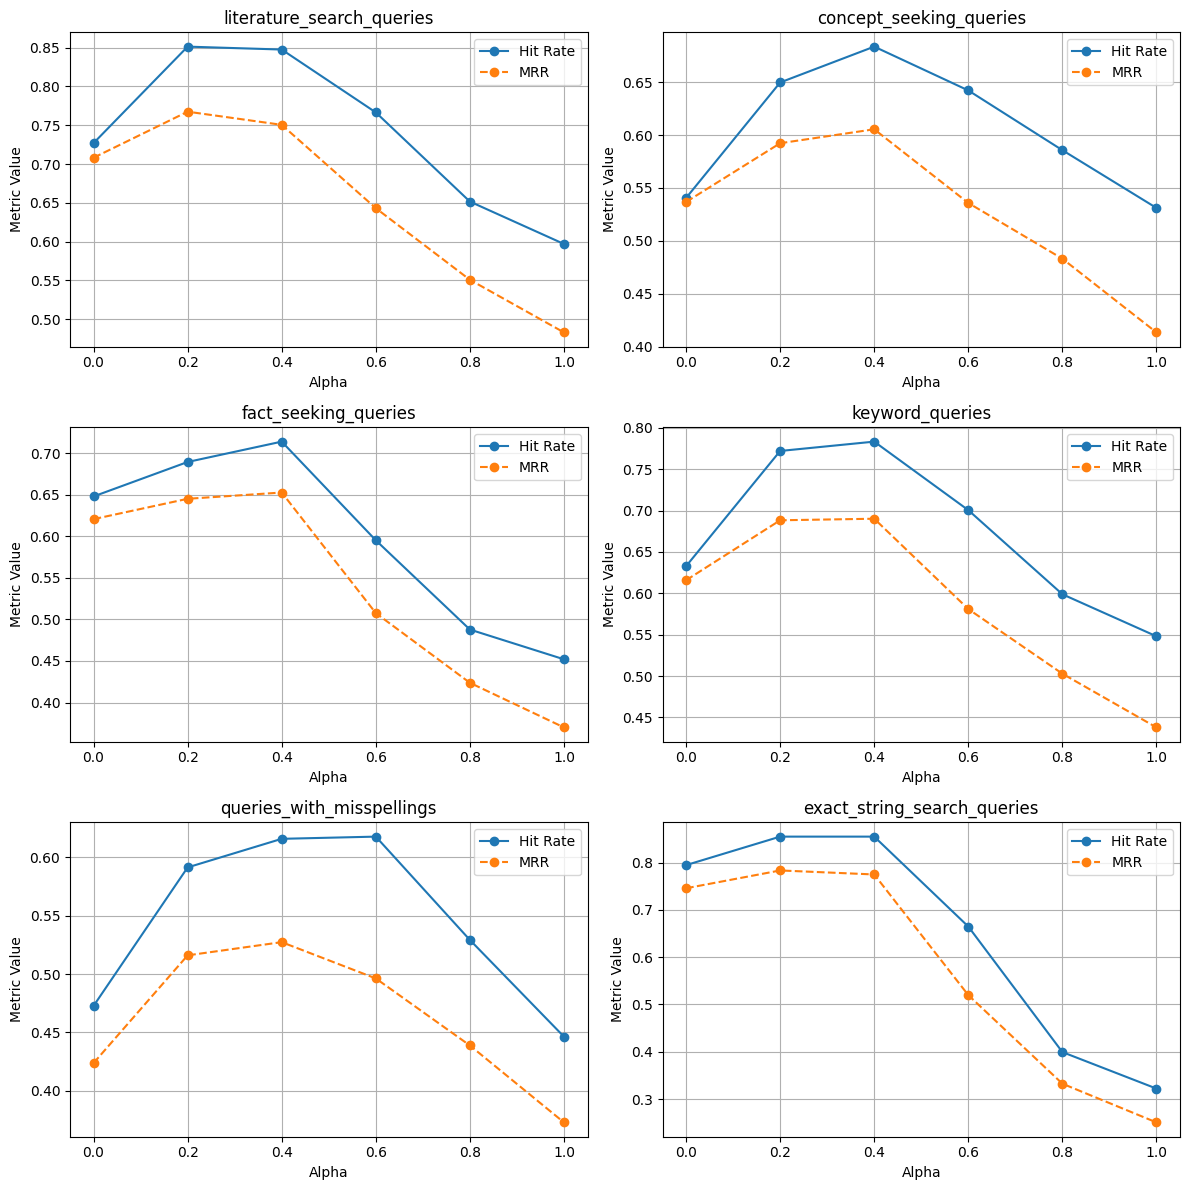

In [ ]:
import nest_asyncio
import asyncio

nest_asyncio.apply()

asyncio.run(main())